In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns

plt.style.use('ggplot')
pd.options.display.float_format = '{:.2f}'.format 

In [61]:
df_prod = pd.read_csv("./raw_data/production-quantity_raw.csv")
df_prod.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,QCL,Crops and livestock products,24,Angola,5312,Area harvested,1610,"Coffee, green",1961,1961,ha,350000.00,A,Official figure,NaN
1,QCL,Crops and livestock products,24,Angola,5510,Production,1610,"Coffee, green",1961,1961,t,168600.00,A,Official figure,NaN
2,QCL,Crops and livestock products,24,Angola,5312,Area harvested,1610,"Coffee, green",1962,1962,ha,500000.00,A,Official figure,NaN
3,QCL,Crops and livestock products,24,Angola,5510,Production,1610,"Coffee, green",1962,1962,t,185000.00,A,Official figure,NaN
4,QCL,Crops and livestock products,24,Angola,5312,Area harvested,1610,"Coffee, green",1963,1963,ha,500000.00,E,Estimated value,NaN


##### first data understandings - (PRODUCTION QUANTITY & AREA HARVESTED)

In [62]:
df_prod.shape

(10556, 15)

In [63]:
df_prod.dtypes

Domain Code          object
Domain               object
Area Code (M49)       int64
Area                 object
Element Code          int64
Element              object
Item Code (CPC)       int64
Item                 object
Year Code             int64
Year                  int64
Unit                 object
Value               float64
Flag                 object
Flag Description     object
Note                 object
dtype: object

In [64]:
df_prod.describe()

,Area Code (M49),Element Code,Item Code (CPC),Year Code,Year,Value
count,10556.00,10556.00,10556.00,10556.00,10556.00,10188.00
mean,426.64,5411.32,1610.00,1991.81,1991.81,103928.82
std,245.77,99.00,0.00,18.14,18.14,298442.80
min,24.00,5312.00,1610.00,1961.00,1961.00,0.00
25%,192.00,5312.00,1610.00,1976.00,1976.00,540.00
50%,404.00,5510.00,1610.00,1992.00,1992.00,10000.00
75%,630.00,5510.00,1610.00,2007.00,2007.00,78043.75
max,894.00,5510.00,1610.00,2023.00,2023.00,4462657.00


In [65]:
#Columns to keep: Area Code (M49), Area, Element (make own columns for each element), Year, Unit, Value
df_prod = df_prod.drop(['Domain Code', 'Domain', 'Element Code', 'Item Code (CPC)', 'Year Code', 'Flag', 'Flag Description', 'Note'], axis=1)

In [66]:
df_prod.head()

,Area Code (M49),Area,Element,Item,Year,Unit,Value
0,24,Angola,Area harvested,"Coffee, green",1961,ha,350000.00
1,24,Angola,Production,"Coffee, green",1961,t,168600.00
2,24,Angola,Area harvested,"Coffee, green",1962,ha,500000.00
3,24,Angola,Production,"Coffee, green",1962,t,185000.00
4,24,Angola,Area harvested,"Coffee, green",1963,ha,500000.00


In [67]:
#rearrange dataframe to have elements as own columns
df_prod = df_prod.pivot_table(
    index=['Area Code (M49)', 'Area', 'Year'],
    columns='Element',
    values='Value'
).reset_index() 

In [68]:
#renaming columns
df_prod = df_prod.rename(columns={"Area Code (M49)":"Area_code", "Area harvested":"Area_harvested_hectar", "Production":"Production_quantity_tonnes"})

In [69]:
df_prod.head()

Element,Area_code,Area,Year,Area_harvested_hectar,Production_quantity_tonnes
0,24,Angola,1961,350000.00,168600.00
1,24,Angola,1962,500000.00,185000.00
2,24,Angola,1963,500000.00,168300.00
3,24,Angola,1964,500000.00,198200.00
4,24,Angola,1965,500000.00,205000.00


In [70]:
#get top countries with high green coffee production quantity on average
top_producer = df_prod.groupby("Area")[["Production_quantity_tonnes"]].mean().sort_values(by=["Production_quantity_tonnes"], ascending=False).head(8)

In [71]:
top_producer.head(15)

Element,Production_quantity_tonnes
Area,
Brazil,1912080.68
Colombia,655110.90
Viet Nam,535367.43
Indonesia,435206.09
Ethiopia,320333.47
Mexico,250006.22
Guatemala,199471.56
Côte d'Ivoire,198883.18


In [72]:
#formatter for million numbers
def formatter(x, pos):
    """Formatiert eine Zahl in Millionen mit zwei Nachkommastellen."""
    return f'{x / 1_000_000:.2f}'

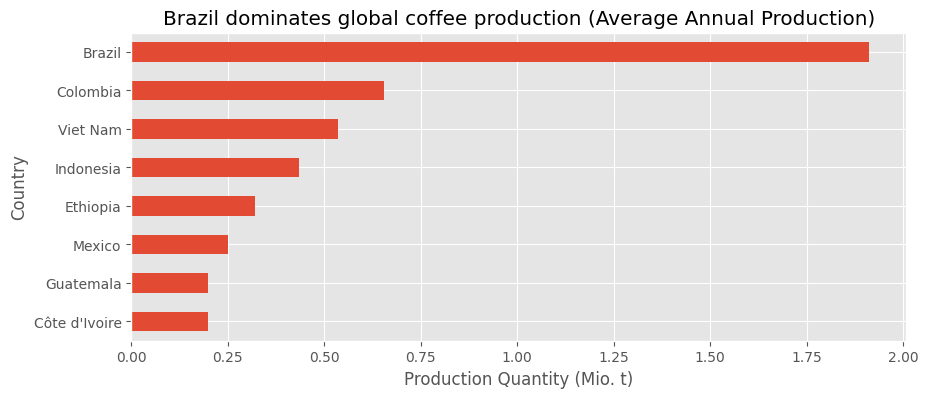

In [73]:
#plot top producing countries
ax = top_producer.plot(kind="barh", title="Brazil dominates global coffee production (Average Annual Production)", 
                       legend=False, figsize=(10,4))
plt.gca().invert_yaxis()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(formatter))
ax.set_ylabel("Country")
ax.set_xlabel("Production Quantity (Mio. t)")
plt.show()

In [74]:
top_harvester = df_prod.groupby("Area")[["Area_harvested_hectar"]].mean().sort_values(by=["Area_harvested_hectar"], ascending=False).head(8)

In [75]:
top_harvester

Element,Area_harvested_hectar
Area,
Brazil,2403731.95
Colombia,857889.21
Indonesia,796926.02
Côte d'Ivoire,771125.95
Mexico,576365.46
Ethiopia PDR,473115.41
Ethiopia,465562.13
Uganda,307538.19


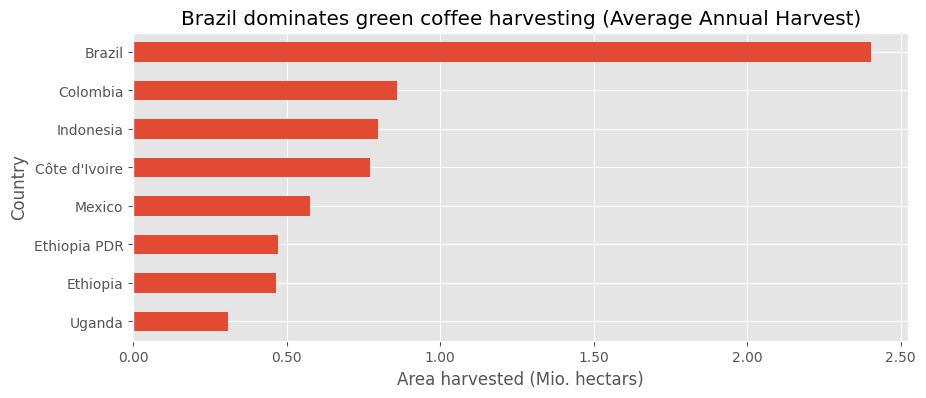

In [79]:
#plot top harvester countries
ax = top_harvester.plot(kind="barh", title="Brazil dominates green coffee harvesting (Average Annual Harvest)", 
                       legend=False, figsize=(10,4))
plt.gca().invert_yaxis()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(formatter))
ax.set_ylabel("Country")
ax.set_xlabel("Area harvested (Mio. hectars)")
plt.show()